# Embedding Clustering Comparison (Baseline vs Histopathology‑Aligned)

This notebook loads two `.pt` files (PyTorch) containing embeddings and labels, reduces them to 2D using **UMAP** (with an automatic **t‑SNE** fallback if UMAP isn't installed), and plots them **side by side** colored by ISUP grade.

**How to use:**
1. Set the file paths in the **Parameters** cell below.
2. Run all cells. If UMAP isn't installed locally, install it with `pip install umap-learn` and re-run.
3. Compare the clustering visually; optional silhouette scores are computed as a crude quantitative check.


In [120]:
# === Parameters ===
BASELINE_PT = "/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/results_no_loading/baseline/test_embeddings/test.pt"   # e.g., ".../baseline/best_embeddings/val.pt"
ALIGNED_PT  = "/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/results_no_loading/triplet/test_embeddings/test.pt"    # e.g., ".../histalign/best_embeddings/val.pt"

# Optional: label names for legend (index == class id). If None, integer ids are used.
LABEL_NAMES = ["ISUP01", "ISUP23", "ISUP45"]  # set to None to disable

# Optional: subsample to speed up plotting (set to None to use all points)
SAMPLE_N = None  # e.g., 5000

# Random seed for reproducibility in UMAP / t-SNE (when applicable)
SEED = 42


In [121]:
import os
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt

# Try UMAP first; fallback to t-SNE if unavailable
reducer_name = "UMAP"
try:
    import umap
    def make_reducer():
        reducer = umap.UMAP(
        n_neighbors=30,
        min_dist=0.03,
        metric="correlation",          # often better than cosine on embeddings
        target_metric="categorical",
        target_weight=0.35,            # dialed back
        target_n_neighbors=15,
        repulsion_strength=1.8,
        densmap=True,
        random_state=SEED,
    )



        return reducer
        
except Exception as e:
    from sklearn.manifold import TSNE
    reducer_name = "t-SNE (fallback)"
    def make_reducer(seed=42, **kw):
        # keep interface-compatible
        return TSNE(n_components=2, random_state=seed)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
print("Reducer:", reducer_name)


Reducer: UMAP


In [122]:
def load_pt_embeddings_labels(pt_path):
    """Load a .pt file expecting at least 'embeddings' and (ideally) 'labels' keys.

    Returns (X: np.ndarray [N,D], y: np.ndarray [N], names: Optional[list])
"""
    d = torch.load(pt_path, map_location="cpu")
    X = d.get("embeddings", None)
    if X is None:
        raise ValueError(f"{pt_path} is missing key 'embeddings'")
    if isinstance(X, torch.Tensor):
        X = X.detach().cpu().numpy()
    elif isinstance(X, np.ndarray):
        pass
    else:
        raise TypeError(f"Unsupported embeddings type: {type(X)} (expected torch.Tensor or np.ndarray)")
    if X.ndim != 2:
        raise ValueError(f"Embeddings must be 2D [N,D], got shape {X.shape}")
    # labels (optional but recommended)
    y = d.get("labels", d.get("y", None))
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()
    elif y is None:
        # create dummy zeros if missing
        y = np.zeros((X.shape[0],), dtype=np.int64)
        print(f"Warning: no labels found in {pt_path}; defaulting to zeros.")
    # names (optional)
    names = d.get("names", None)
    return X, y, names


In [123]:
def maybe_subsample(X, y, n=None, seed=42):
    if n is None or n <= 0 or n >= len(X):
        return X, y
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=n, replace=False)
    return X[idx], y[idx]


In [124]:
# --- Load ---
X_base, y_base, _ = load_pt_embeddings_labels(BASELINE_PT)
X_align, y_align, _ = load_pt_embeddings_labels(ALIGNED_PT)

print("Baseline:", X_base.shape, "labels:", y_base.shape)
print("Aligned :", X_align.shape, "labels:", y_align.shape)

# Optional subsample for speed/clarity
X_base, y_base = maybe_subsample(X_base, y_base, SAMPLE_N, seed=SEED)
X_align, y_align = maybe_subsample(X_align, y_align, SAMPLE_N, seed=SEED)


Baseline: (6762, 512) labels: (6762,)
Aligned : (6762, 512) labels: (6762,)


In [125]:
# --- Scale features (independently per set) ---
scaler_b = StandardScaler().fit(X_base)
Xb = scaler_b.transform(X_base)

scaler_a = StandardScaler().fit(X_align)
Xa = scaler_a.transform(X_align)


In [130]:
# --- 2D reduction ---
# reducer = make_reducer()
# Zb = reducer.fit_transform(Xb, y_base)
# Za = reducer.fit_transform(Xa, y_align)

from sklearn.decomposition import PCA
Xb_pca = PCA(n_components=50, random_state=SEED).fit_transform(Xb)
Xa_pca = PCA(n_components=50, random_state=SEED).fit_transform(Xa)

reducer = umap.UMAP(
    n_neighbors=40,          # a bit more global structure
    min_dist=0.02,           # allow compact clusters
    metric="correlation",
    target_metric="categorical",
    target_weight=0.55,      # moderate label pull
    target_n_neighbors=15,
    repulsion_strength=1.8,  # pushes islands apart slightly more
    densmap=False,           # often makes separation look cleaner
    random_state=SEED,
)
Zb = reducer.fit_transform(Xb_pca, y_base)
Za = reducer.fit_transform(Xa_pca, y_align)

print("Reduced shapes:", Zb.shape, Za.shape)


/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reduced shapes: (6762, 2) (6762, 2)


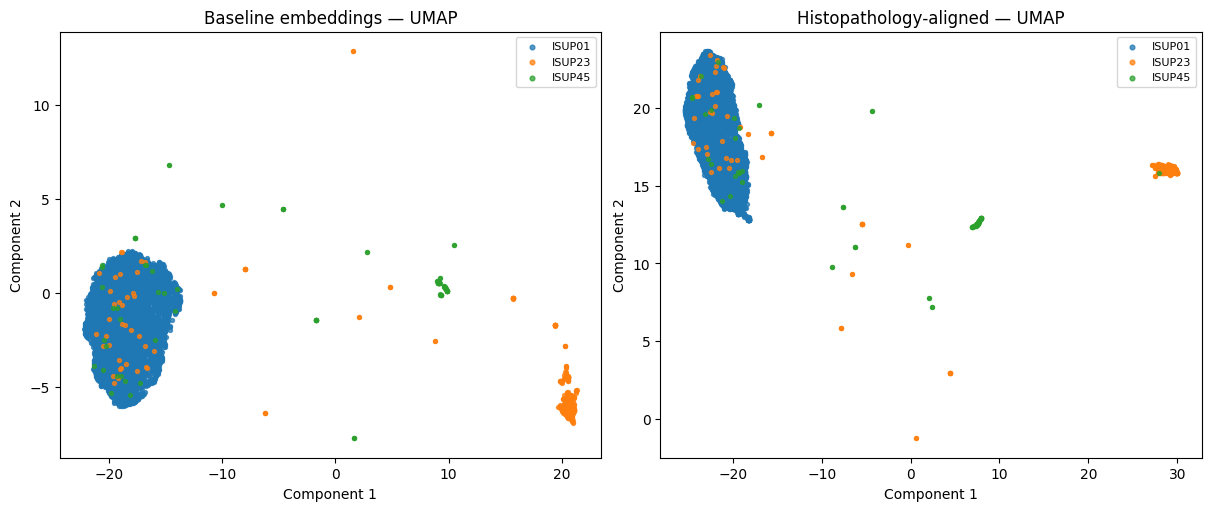

In [131]:
# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

def plot_scatter(ax, Z, y, title):
    classes = np.unique(y)
    for c in classes:
        m = (y == c)
        label = LABEL_NAMES[c] if (LABEL_NAMES is not None and c < len(LABEL_NAMES)) else f"class {c}"
        # DO NOT set explicit colors (per instruction) — let matplotlib choose automatically
        ax.scatter(Z[m, 0], Z[m, 1], s=8, alpha=0.75, label=label)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(loc="best", fontsize=8, markerscale=1.2)

plot_scatter(axes[0], Zb, y_base, f"Baseline embeddings — {reducer_name}")
plot_scatter(axes[1], Za, y_align, f"Histopathology‑aligned — {reducer_name}")

plt.show()


In [132]:
# --- Optional: silhouette score for a crude quantitative comparison (higher is better) ---
def safe_silhouette(X2d, y):
    # silhouette needs at least 2 labels with >1 sample
    uniq, cnts = np.unique(y, return_counts=True)
    if len(uniq) < 2 or np.any(cnts < 2):
        return np.nan
    try:
        return float(silhouette_score(X2d, y))
    except Exception:
        return np.nan

sil_base = safe_silhouette(Zb, y_base)
sil_align = safe_silhouette(Za, y_align)
print(f"Silhouette (baseline): {sil_base:.4f} | Silhouette (aligned): {sil_align:.4f}")


Silhouette (baseline): 0.7708 | Silhouette (aligned): 0.7957


In [133]:
# # --- Optional: save figure ---
# OUT_DIR = Path("./figs")
# OUT_DIR.mkdir(parents=True, exist_ok=True)
# fig_path = OUT_DIR / "umap_comparison.png"
# plt.figure(figsize=(12, 5))
# # re-plot quickly to save
# fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
# def quick(ax, Z, y, ttl):
#     classes = np.unique(y)
#     for c in classes:
#         m = (y == c)
#         lbl = LABEL_NAMES[c] if (LABEL_NAMES is not None and c < len(LABEL_NAMES)) else f"class {c}"
#         ax.scatter(Z[m, 0], Z[m, 1], s=8, alpha=0.75, label=lbl)
#     ax.set_title(ttl); ax.set_xlabel("Component 1"); ax.set_ylabel("Component 2"); ax.legend(loc="best", fontsize=8, markerscale=1.2)

# quick(axes[0], Zb, y_base, f"Baseline — {reducer_name}")
# quick(axes[1], Za, y_align, f"Aligned — {reducer_name}")
# fig.savefig(fig_path, dpi=150)
# print("Saved figure to:", fig_path)
